## Install dependencies

In [ ]:
from polars.dependencies import numpy
!pip install --force-reinstall bioframe==0.7.2 pyarrow fastparquet pyranges==0.1.2 pybedtools==0.10.0 git+https://gitlab.com/gtamazian/pygenomics.git

## Setup the environment


In [1]:
%env BENCH_DATA_ROOT=/Users/mwiewior/research/git/openstack-bdg-runners/ansible/roles/gha_runner/files/databio
%env SEQUILA_CLI=/Users/mwiewior/CLionProjects/sequila-native/target/release/sequila-cli

env: BENCH_DATA_ROOT=/Users/mwiewior/research/git/openstack-bdg-runners/ansible/roles/gha_runner/files/databio
env: SEQUILA_CLI=/Users/mwiewior/CLionProjects/sequila-native/target/release/sequila-cli


In [2]:
import os
BENCH_DATA_ROOT= os.getenv('BENCH_DATA_ROOT', '/data/bench_data/databio/')

In [3]:
import pandas as pd

In [4]:
df_0=pd.read_parquet(f'{BENCH_DATA_ROOT}/chainRn4/', engine='pyarrow')
df_1=pd.read_parquet(f'{BENCH_DATA_ROOT}/fBrain-DS14718/', engine='pyarrow')
df_3=pd.read_parquet(f'{BENCH_DATA_ROOT}/chainOrnAna1/', engine='pyarrow')
df_7=pd.read_parquet(f'{BENCH_DATA_ROOT}/ex-anno/', engine='pyarrow')
df_8=pd.read_parquet(f'{BENCH_DATA_ROOT}/ex-rna/', engine='pyarrow')

In [ ]:
import bioframe as bf

bf.overlap(df_0, df_1,cols1=('contig','pos_start','pos_end'), cols2=('contig','pos_start','pos_end'), how="inner").count()

In [ ]:
%%bash
$SEQUILA_CLI --file queries/0-1.sql

In [ ]:
bf.overlap(df_0, df_3,cols1=('contig','pos_start','pos_end'), cols2=('contig','pos_start','pos_end'), how="inner").count()

In [ ]:
%%bash
$SEQUILA_CLI --file queries/0-3.sql

In [ ]:
bf.overlap(df_0, df_8,cols1=('contig','pos_start','pos_end'), cols2=('contig','pos_start','pos_end'), how="inner").count()

In [ ]:
%%bash
$SEQUILA_CLI --file queries/0-8.sql

In [ ]:
bf.overlap(df_7, df_8,cols1=('contig','pos_start','pos_end'), cols2=('contig','pos_start','pos_end'), how="inner").count()

In [ ]:
%%bash
$SEQUILA_CLI --file queries/7-8.sql

### pyranges

In [ ]:
import pyranges as pr

def df2pr(df):
    return pr.PyRanges(
        chromosomes=df.contig,
        starts=df.pos_start,
        ends=df.pos_end,
    )

In [ ]:
df_0_pr = df2pr(df_0)
df_1_pr = df2pr(df_1)
df_3_pr = df2pr(df_3)
df_7_pr = df2pr(df_7)
df_8_pr = df2pr(df_8)

In [ ]:
len(df_0_pr.join(df_1_pr))

In [ ]:
len(df_0_pr.join(df_3_pr))

In [ ]:
len(df_0_pr.join(df_8_pr))

In [ ]:
len(df_7_pr.join(df_8_pr))

### pybedtools

In [5]:
import pybedtools


In [6]:
df_0_bed = pybedtools.BedTool.from_dataframe(df_0)
df_1_bed = pybedtools.BedTool.from_dataframe(df_1)
df_3_bed = pybedtools.BedTool.from_dataframe(df_3)
df_7_bed = pybedtools.BedTool.from_dataframe(df_7)
df_8_bed = pybedtools.BedTool.from_dataframe(df_8)

In [ ]:
df_0_bed.intersect(df_1_bed).count()

In [7]:
df_0_bed.intersect(df_3_bed).count()

1086692495

In [ ]:
df_0_bed.intersect(df_8_bed).count()

In [ ]:
df_7_bed.intersect(df_8_bed).count()

### pygenomics

In [ ]:
from pygenomics.interval import GenomicBase, GenomicInterval
import itertools


In [ ]:
df_0_pg = GenomicBase([(r.contig, r.pos_start, r.pos_end) for r in df_0.itertuples()])

In [ ]:
df_1_pg = GenomicBase([(r.contig, r.pos_start, r.pos_end) for r in df_1.itertuples()])

In [ ]:
df_7_pg = GenomicBase([(r.contig, r.pos_start, r.pos_end) for r in df_7.itertuples()])

In [ ]:
df_1_a = df_1.values.tolist()
df_3_a = df_3.values.tolist()
df_8_a = df_8.values.tolist()



In [ ]:
df_1_a[1]

In [ ]:
len(list(itertools.chain.from_iterable([df_0_pg.find_all((r[0], r[1], r[2])) for r in df_1_a])))

In [ ]:
#slower than array
#len(list(itertools.chain.from_iterable([df_0_pg.find_all((r.contig, r.pos_start, r.pos_end)) for r in df_3.itertuples()])))


In [ ]:
len(list(itertools.chain.from_iterable([df_0_pg.find_all((r[0], r[1], r[2])) for r in df_3_a])))

In [ ]:
len(list(itertools.chain.from_iterable([df_0_pg.find_all((r[0], r[1], r[2])) for r in df_8_a])))

In [ ]:
len(list(itertools.chain.from_iterable([df_7_pg.find_all((r.contig, r.pos_start, r.pos_end)) for r in df_8.itertuples()])))

In [ ]:
len(list(itertools.chain.from_iterable([df_7_pg.find_all((r[0], r[1], r[2])) for r in df_8_a ])))

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def plot_metrics(metrics, labels, title):
    x = np.arange(len(labels))  # the label locations
    width = 0.10  # the width of the bars
    fig, ax = plt.subplots()
    k = 0
    for m in metrics:
        ax.bar(
            x + width * k,
            [metrics[m]["0-1"], metrics[m]["0-3"], metrics[m]["0-8"], metrics[m]["7-8"]],
            width,
            label=m,
        )
        k += 1
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Time [s]")
    ax.set_title(title)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)
    ax.grid(True)
    fig.set_size_inches(10, 5)
    plt.show()

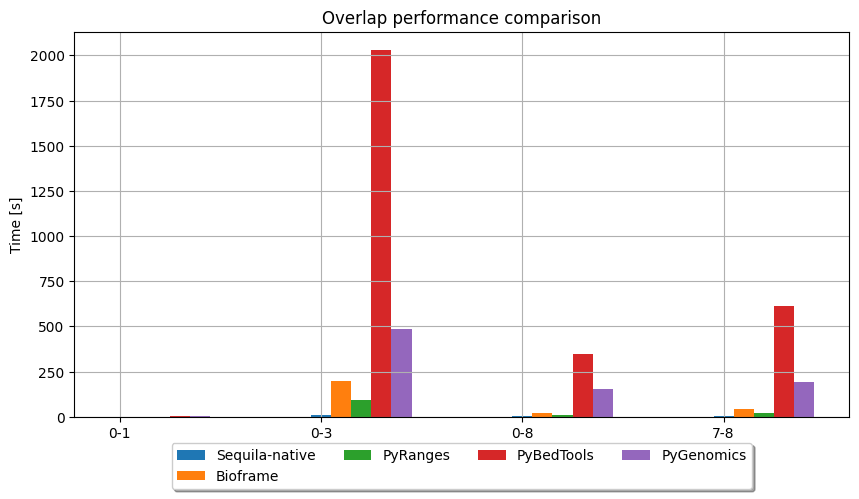

In [2]:
#pygenomic uses ge/lte for comparison - results differ

metrics = {
    "Sequila-native": {"0-1": 0.144, "0-3": 9.425, "0-8": 3.374, "7-8": 4.756},
    "Bioframe": {"0-1": 0.559, "0-3": 196.0, "0-8": 21.128, "7-8": 41.103},
    "PyRanges": {"0-1": 0.135, "0-3": 92.0, "0-8": 10.629, "7-8": 19.461},
    "PyBedTools": {"0-1": 1.512, "0-3": 2029.0, "0-8": 350.0, "7-8": 611.0},
    "PyGenomics": {"0-1": 1.579, "0-3": 487.0, "0-8": 153.0, "7-8": 193},
}
plot_metrics(
    metrics, ["0-1", "0-3", "0-8","7-8"], "Overlap performance comparison"
)